## 1.创建工作区

In [74]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "9_unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 2.聚类cluster

**Introduction – Classification _vs_ Clustering**

In [75]:
from sklearn.datasets import load_iris

In [76]:
from sklearn.datasets import load_iris

# 加载鸢尾花数据集
data = load_iris()

# 获取特征矩阵和标签
X = data.data
y = data.target

# 查看目标类别名称
print("特征矩阵形状:", X.shape)
print("标签数组形状:", y.shape)
print("目标类别名称:", data.target_names)

特征矩阵形状: (150, 4)
标签数组形状: (150,)
目标类别名称: ['setosa' 'versicolor' 'virginica']


Saving figure classification_vs_clustering_plot


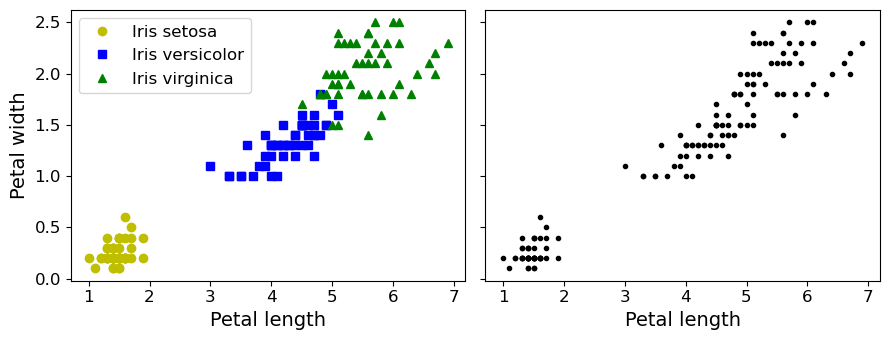

In [77]:
import matplotlib.pyplot as plt

# 创建图形
plt.figure(figsize=(9, 3.5))

# 左图：分类问题（有标签）
plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")        # 黄色圆圈
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")    # 蓝色方块
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")     # 绿色三角
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

# 右图：聚类问题（无标签）
plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")   # 黑色散点图
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)                    # 隐藏y轴刻度标签

# 保存并显示图形
save_fig("classification_vs_clustering_plot")
plt.show()

# 分类：有监督学习，需要标签
# 聚类：无监督学习，不需要标签

A Gaussian mixture model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).

In [78]:
from sklearn.mixture import GaussianMixture

In [79]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Let's map each cluster to a class. Instead of hard coding the mapping (as is done in the book, for simplicity), we will pick the most common class for each cluster (using the `scipy.stats.mode()` function):

In [80]:
from scipy import stats
import numpy as np

# 创建映射字典
mapping = {}

# 为每个真实类别找到对应的聚类标签
for class_id in np.unique(y):
    # 获取当前类别中最常见的聚类标签
    mode = stats.mode(y_pred[y==class_id])
    # 建立映射关系
    mapping[mode.mode] = class_id

print("聚类标签到真实标签的映射:", mapping)

# 聚类标签 1 → 真实标签 0 (setosa)
# 聚类标签 2 → 真实标签 1 (versicolor)
# 聚类标签 0 → 真实标签 2 (virginica)

聚类标签到真实标签的映射: {1: 0, 2: 1, 0: 2}


In [81]:
# 将聚类标签转换为真实标签
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

# 验证转换结果
print("转换前的标签映射:", mapping)
print("转换后的标签分布:", np.bincount(y_pred))
print("真实标签分布:", np.bincount(y))

转换前的标签映射: {1: 0, 2: 1, 0: 2}
转换后的标签分布: [50 45 55]
真实标签分布: [50 50 50]


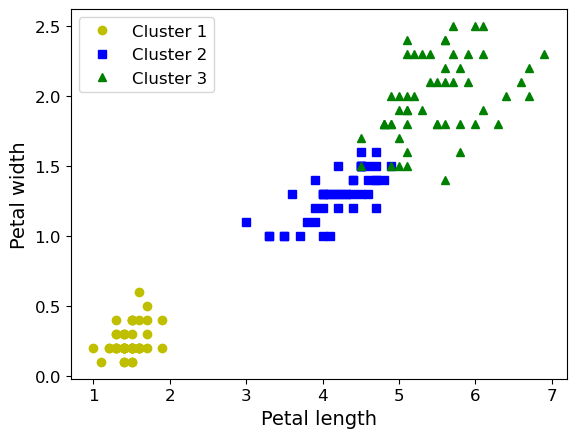

In [82]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [83]:
np.sum(y_pred==y)

145

In [84]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

**Note**: the results in this notebook may differ slightly from the book. This is because algorithms can sometimes be tweaked a bit between Scikit-Learn versions.

### K-Means

Let's start by generating some blobs:

In [85]:
from sklearn.datasets import make_blobs

In [86]:
# 定义簇中心点
blob_centers = np.array([
    [ 0.2,  2.3],  # 第一个簇的中心
    [-1.5,  2.3],  # 第二个簇的中心
    [-2.8,  1.8],  # 第三个簇的中心
    [-2.8,  2.8],  # 第四个簇的中心
    [-2.8,  1.3]   # 第五个簇的中心
])

# 定义每个簇的标准差
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [87]:
# 生成数据点
X, y = make_blobs(
    n_samples=2000,         # 生成2000个样本
    centers=blob_centers,   # 使用预定义的簇中心
    cluster_std=blob_std,   # 使用预定义的标准差
    random_state=7          # 设置随机种子
)

print(f"生成数据形状: {X.shape}")
print(f"唯一标签: {np.unique(y)}")

生成数据形状: (2000, 2)
唯一标签: [0 1 2 3 4]


Now let's plot them:

In [88]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


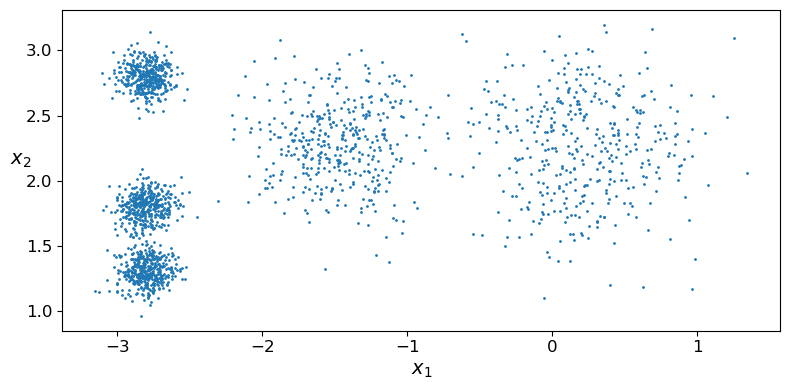

In [89]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

**Fit and predict**

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [90]:
from sklearn.cluster import KMeans

In [91]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the 5 clusters:

In [92]:
y_pred

array([0, 0, 4, ..., 3, 1, 0])

In [93]:
y_pred is kmeans.labels_

True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [94]:
kmeans.cluster_centers_

array([[-2.80214068,  1.55162671],
       [ 0.08703534,  2.58438091],
       [-1.46869323,  2.28214236],
       [-2.79290307,  2.79641063],
       [ 0.31332823,  1.96822352]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

- 1、保存标签

KMeans实例会保存训练数据被分配的簇的索引，这些索引就是所谓的"标签"
- 2、容易混淆的点

这里的"标签"不是监督学习中的真实标签，而是每个数据点被分配到的簇的编号（0, 1, 2...）

In [95]:
kmeans.labels_

array([0, 0, 4, ..., 3, 1, 0])

Of course, we can predict the labels of new instances:

In [96]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([4, 4, 3, 3])

**Decision Boundaries**

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [97]:
import numpy as np
import matplotlib.pyplot as plt

def plot_data(X):
    """绘制数据点"""
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    """绘制聚类中心点"""
    # 如果有权重，只显示权重较大的中心点
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    # 绘制白色圆圈
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    # 绘制黑色交叉
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    """绘制聚类的决策边界"""
    # 计算数据范围
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    
    # 创建网格点
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    
    # 预测网格点的类别
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 绘制决策边界
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    
    # 绘制数据点
    plot_data(X)
    
    # 绘制聚类中心
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    # 设置轴标签
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


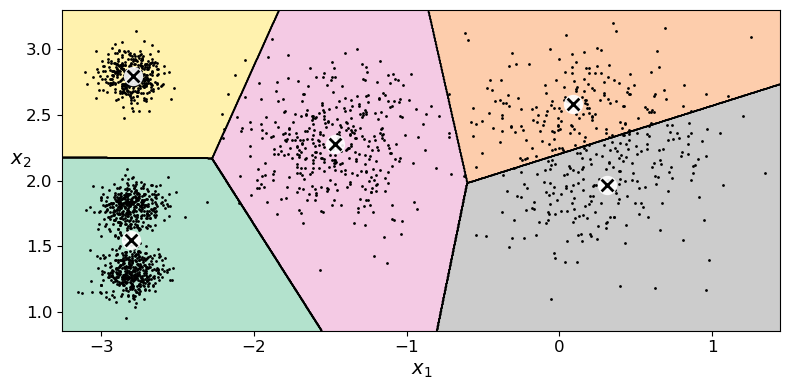

In [98]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

**Hard Clustering _vs_ Soft Clustering**

Rather than arbitrarily choosing the closest cluster for each instance, which is called _hard clustering_, it might be better measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:
- 硬聚类：每个样本只属于一个簇（通过predict()方法）
- 距离测量：计算样本到所有簇中心的距离（通过transform()方法）

In [99]:
kmeans.transform(X_new)

array([[2.83778629, 0.59082671, 1.4955481 , 2.9042344 , 0.31493543],
       [5.81943941, 2.9710039 , 4.47759126, 5.84739223, 2.68685968],
       [1.4618254 , 3.11488787, 1.6912185 , 0.29040966, 3.47026031],
       [0.96879317, 3.08818836, 1.54672634, 0.36159148, 3.35573094]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [100]:
import numpy as np

# 假设 X_new 是新数据点，k是聚类数量
# 步骤分解
# 1. np.tile(X_new, (1, k)) - 复制X_new k次
# 2. reshape(-1, k, 2) - 重塑为3D数组，每个点有k个副本
# 3. 减去聚类中心 - kmeans.cluster_centers_
# 4. 计算欧氏距离 - np.linalg.norm(..., axis=2)

distances = np.linalg.norm(
    np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, 
    axis=2
)

print("每个新样本点到各聚类中心的距离:", distances)

每个新样本点到各聚类中心的距离: [[2.83778629 0.59082671 1.4955481  2.9042344  0.31493543]
 [5.81943941 2.9710039  4.47759126 5.84739223 2.68685968]
 [1.4618254  3.11488787 1.6912185  0.29040966 3.47026031]
 [0.96879317 3.08818836 1.54672634 0.36159148 3.35573094]]


#### The K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

- K-Means算法步骤解析

1. **初始化阶段**
- 从数据集中随机选择k个点作为初始聚类中心
- 这k个点就是初始的质心(centroids)

2. **迭代阶段**
- 重复以下步骤直到收敛：
  1. 分配：将每个数据点分配给最近的质心
  2. 更新：重新计算每个簇的质心（计算属于该簇的所有点的均值）


The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [101]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

And let's plot this:

Saving figure kmeans_algorithm_plot


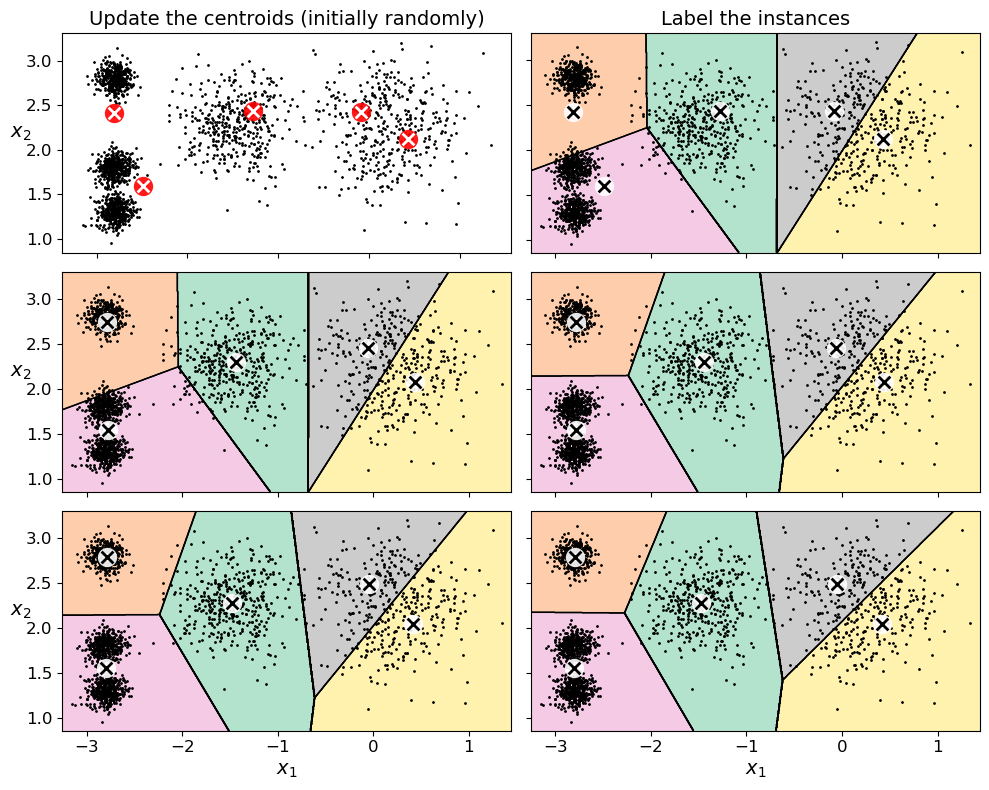

In [102]:
import matplotlib.pyplot as plt

# 创建画布
plt.figure(figsize=(10, 8))

# 第一行：初始随机质心
plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

# 第二行：第一次迭代
plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

# 第三行：第二次迭代
plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

# 保存并显示图形
save_fig("kmeans_algorithm_plot")
plt.show()

**K-Means Variability**

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [103]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


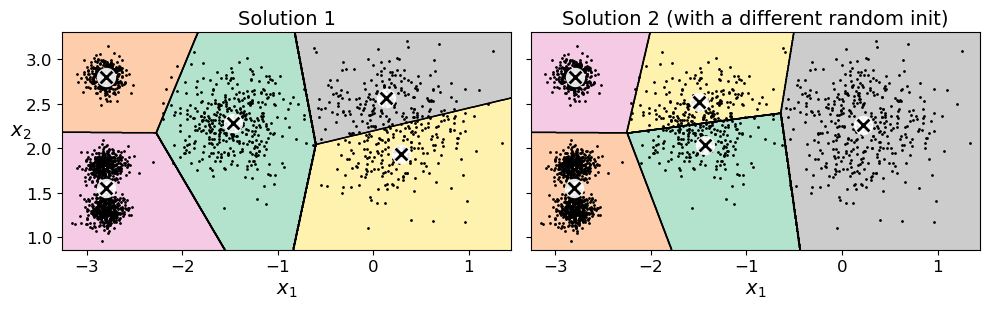

In [104]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 创建两个不同随机初始化的KMeans实例
kmeans_rnd_init1 = KMeans(
    n_clusters=5,        # 5个簇
    init="random",       # 随机初始化
    n_init=1,           # 运行一次
    algorithm="full",    # 完整算法
    random_state=2      # 随机种子2
)

kmeans_rnd_init2 = KMeans(
    n_clusters=5,
    init="random",
    n_init=1,
    algorithm="full",
    random_state=5      # 随机种子5
)

# 对比两个模型的聚类结果
plot_clusterer_comparison(
    kmeans_rnd_init1, 
    kmeans_rnd_init2, 
    X,
    "Solution 1", 
    "Solution 2 (with a different random init)"
)

# 保存并显示图形
save_fig("kmeans_variability_plot")
plt.show()

#### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_（惯性） metric:

- 1.问题
    - 聚类是无监督学习，没有真实标签
    - 需要其他方式评估模型好坏
- 2.解决方案：惯性(inertia)
    - 计算每个样本到其所属簇中心的距离平方和
    - 距离越小，聚类效果越好

In [105]:
kmeans.inertia_

219.4280007364759

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [106]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

219.4280007364774

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_greater is better_" rule.

In [107]:
kmeans.score(X)

-219.4280007364759

#### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia（最小惯性）. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [108]:
kmeans_rnd_init1.inertia_

219.5820150360229

In [109]:
kmeans_rnd_init2.inertia_

239.1922640341045

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [110]:
from sklearn.cluster import KMeans

# n_init=10表示运行10次不同的随机初始化
kmeans_rnd_10_inits = KMeans(
    n_clusters=5,        # 5个簇
    init="random",       # 随机初始化
    n_init=10,          # 运行10次，选择最佳结果
    algorithm="full",    # 完整算法
    random_state=2      # 随机种子
)

# 拟合数据
kmeans_rnd_10_inits.fit(X)

# 输出最佳运行的惯性值
print(f"最佳运行的惯性值: {kmeans_rnd_10_inits.inertia_}")

最佳运行的惯性值: 211.59853725816836


As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

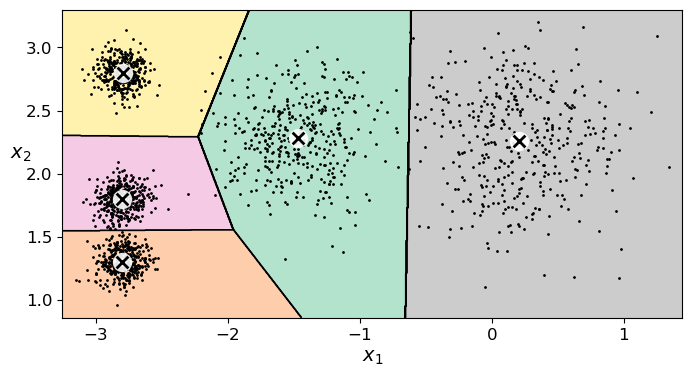

In [111]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

#### Centroid initialization methods

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

*K-Means++算法分析*
- 核心思想
    - 改进K-Means的初始化方法
    - 使质心之间尽可能分散
    - 减少算法收敛到局部最优解的概率
- 算法步骤
    - 随机选择第一个质心
    - 计算每个点被选为下一个质心的概率
    - 概率与该点到已有质心的最短距离的平方成正比

In [112]:
KMeans()

KMeans()

In [113]:
import numpy as np
from sklearn.cluster import KMeans

# 自定义初始质心位置
good_init = np.array([
    [-3, 3],  # 第一个质心
    [-3, 2],  # 第二个质心
    [-3, 1],  # 第三个质心
    [-1, 2],  # 第四个质心
    [0, 2]    # 第五个质心
])

# 创建KMeans模型
kmeans = KMeans(
    n_clusters=5,      # 5个簇
    init=good_init,    # 使用自定义初始化
    n_init=1,          # 只需运行一次
    random_state=42    # 随机种子
)

# 拟合模型并计算惯性值
kmeans.fit(X)
inertia = kmeans.inertia_
print(f"使用自定义初始化的惯性值: {inertia}")

使用自定义初始化的惯性值: 211.59853725816836


#### Accelerated K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

*Elkan算法加速K-Means的分析*
- 利用三角不等式减少距离计算
- 通过记录点到质心的距离上下界来加速

In [114]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

47.6 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [115]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)

22.1 ms ± 767 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


There's no big difference in this case, as the dataset is fairly small.

#### Mini-Batch K-Means

Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches (see [this paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

mini-batch k-means
- 每次使用数据的一个小批次而不是全部数据，减少内存使用和计算时间，适合大规模数据集
- 主要步骤
    - 随机选择小批量数据
    - 对小批量数据执行K-means
    - 更新簇中心
    - 重复以上步骤

In [116]:
from sklearn.cluster import MiniBatchKMeans

In [117]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [118]:
minibatch_kmeans.inertia_

211.658993745743

If the dataset does not fit in memory, the simplest option is to use the `memmap` class, just like we did for incremental PCA in the previous chapter. First let's load MNIST:

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [119]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [120]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

Next, let's write it to a `memmap`:

In [122]:
filename = "my_mnist1.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [123]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

If your data is so large that you cannot use `memmap`, things get more complicated. Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [124]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Now we can train the model by feeding it one batch at a time. We also need to implement multiple initializations and keep the model with the lowest inertia:

In [125]:
np.random.seed(42)

In [126]:
# 参数设置
k = 5                           # 簇的数量
n_init = 10                     # 初始化次数
n_iterations = 100              # 迭代次数
batch_size = 100               # 批量大小
init_size = 500                # K-Means++初始化数据量
evaluate_on_last_n_iters = 10  # 评估最后n次迭代

# 训练过程
best_kmeans = None

for init in range(n_init):
    # 创建模型
    minibatch_kmeans = MiniBatchKMeans(
        n_clusters=k, 
        init_size=init_size
    )
    
    # 初始化训练
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)
    
    # 增量训练
    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        
        # 记录最后几次迭代的惯性值
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_
    
    # 更新最佳模型
    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [127]:
best_kmeans.score(X)

-211.62123584033378

Mini-batch K-Means is much faster than regular K-Means:

In [128]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

18.4 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [129]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

5.9 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's *much* faster! However, its performance is often lower (higher inertia), and it keeps degrading as _k_ increases. Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means:

In [130]:
from timeit import timeit

In [131]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

Saving figure minibatch_kmeans_vs_kmeans


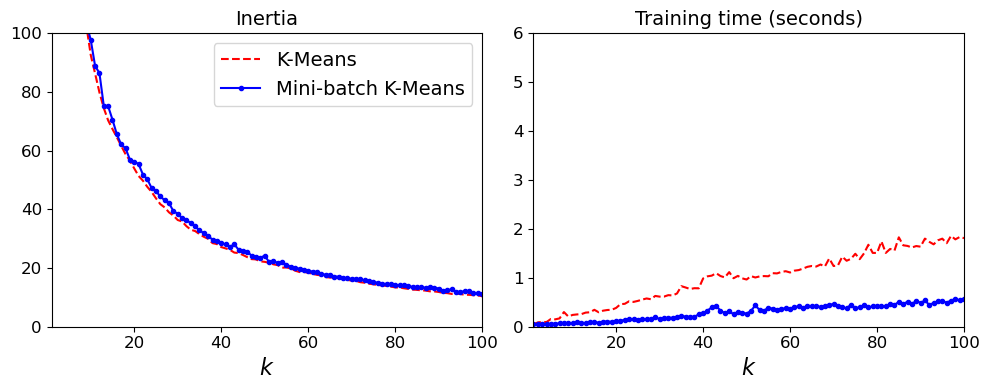

In [132]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

#### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5?

Saving figure bad_n_clusters_plot


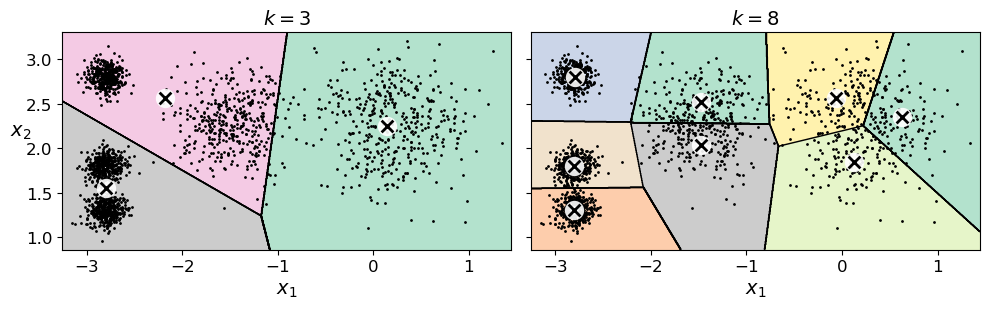

In [133]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [134]:
kmeans_k3.inertia_

653.2167190021551

In [135]:
kmeans_k8.inertia_

119.22484592677118

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [136]:
from sklearn.cluster import KMeans
import numpy as np
import warnings

# 忽略 warnings信息
warnings.filterwarnings("ignore")

# 训练不同k值的模型
kmeans_per_k = [
    KMeans(n_clusters=k, random_state=42).fit(X)
    for k in range(1, 10)  # k从1到9
]

# 计算每个模型的惯性值
inertias = [model.inertia_ for model in kmeans_per_k]

# 打印结果
for k, inertia in enumerate(inertias, start=1):
    print(f"k={k}: inertia={inertia:.0f}") 

k=1: inertia=3535
k=2: inertia=1150
k=3: inertia=653
k=4: inertia=262
k=5: inertia=219
k=6: inertia=169
k=7: inertia=142
k=8: inertia=119
k=9: inertia=103


Saving figure inertia_vs_k_plot


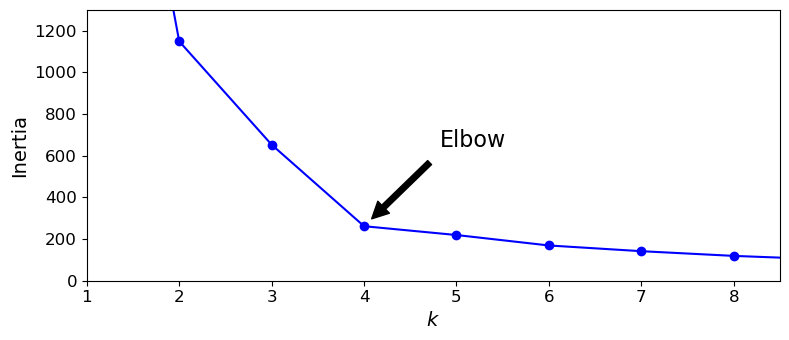

In [137]:
import matplotlib.pyplot as plt

# 创建图形
plt.figure(figsize=(8, 3.5))

# 绘制惯性值曲线
plt.plot(range(1, 10), inertias, "bo-")  # 蓝色圆点加线

# 设置标签
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

# 添加肘部注释
plt.annotate('Elbow',
             xy=(4, inertias[3]),         # 箭头指向点
             xytext=(0.55, 0.55),         # 文本位置
             textcoords='figure fraction', # 使用图形比例坐标
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

# 设置坐标轴范围
plt.axis([1, 8.5, 0, 1300])

# 保存并显示图形
save_fig("inertia_vs_k_plot")
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

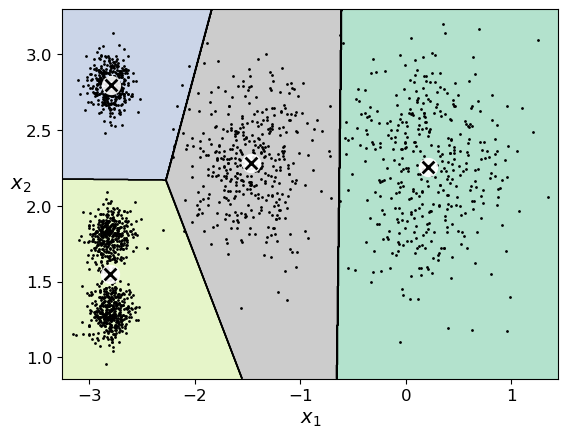

In [138]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Another approach is to look at the _silhouette score_（轮廓分数）, which is the mean _silhouette coefficient_ over all the instances. 

An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). 

The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [139]:
from sklearn.metrics import silhouette_score

In [140]:
silhouette_score(X, kmeans.labels_) # 计算KMeans模型的轮廓系数

0.655517642572828

In [142]:
from sklearn.metrics import silhouette_score

# 计算不同k值的轮廓分数
silhouette_scores = [
    silhouette_score(X, model.labels_)
    for model in kmeans_per_k[1:]  # 从k=2开始，因为k=1时无法计算轮廓分数
]

# 打印结果
for k, score in enumerate(silhouette_scores, start=2):
    print(f"k={k}: silhouette_score={score:.3f}")

k=2: silhouette_score=0.597
k=3: silhouette_score=0.572
k=4: silhouette_score=0.689
k=5: silhouette_score=0.635
k=6: silhouette_score=0.602
k=7: silhouette_score=0.607
k=8: silhouette_score=0.558
k=9: silhouette_score=0.567


Saving figure silhouette_score_vs_k_plot


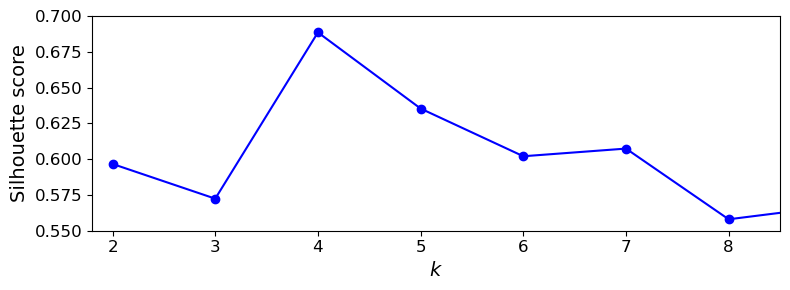

In [143]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

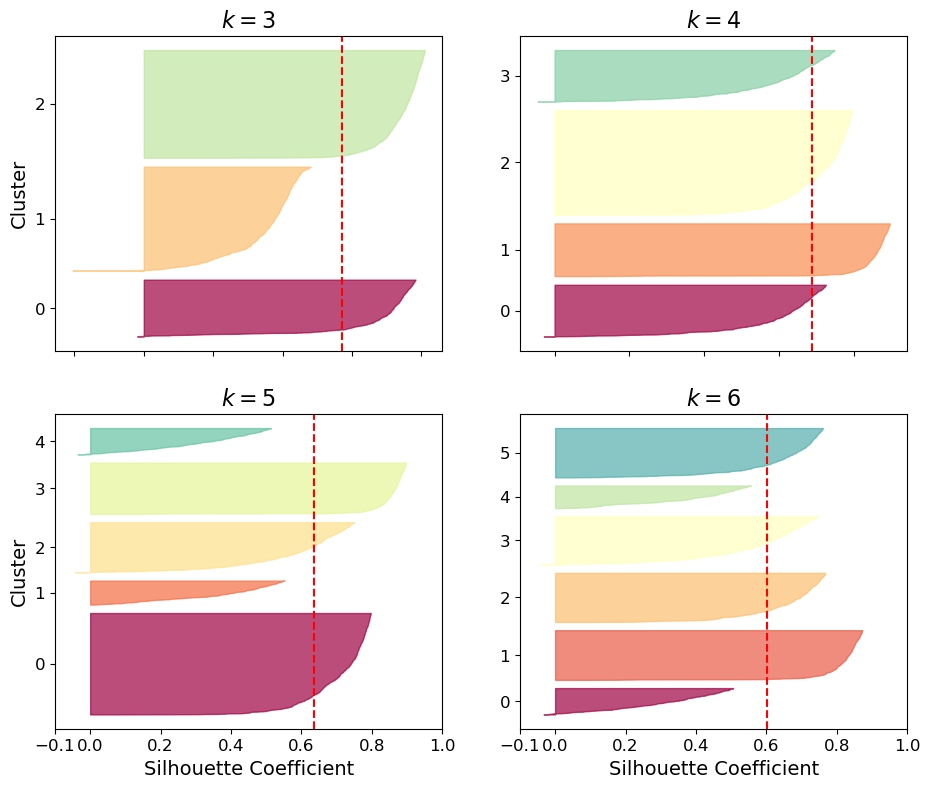

In [144]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

# 创建图形
plt.figure(figsize=(11, 9))

# 对不同的k值进行分析
for k in (3, 4, 5, 6):
    # 创建子图
    plt.subplot(2, 2, k - 2)
    
    # 获取聚类标签和轮廓系数
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    # 设置图形参数
    padding = len(X) // 30
    pos = padding
    ticks = []
    
    # 为每个簇绘制轮廓
    for i in range(k):
        # 获取当前簇的轮廓系数
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        # 使用光谱颜色映射
        color = mpl.cm.Spectral(i / k)
        
        # 绘制轮廓区域
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 
                         0, coeffs,
                         facecolor=color, 
                         edgecolor=color, 
                         alpha=0.7)
                         
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    # 设置坐标轴
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    
    # 设置标签
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    # 添加平均轮廓分数的垂直线 红色虚线
    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

As you can see, $k=5$ looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

### Limits of K-Means

In [145]:
# 生成1000个样本,两个中心点在(4,-4)和(0,0)
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)

# 对数据做线性变换,增加一些旋转和缩放 
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))

# 生成250个样本,单个中心点
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
# 将数据点整体平移到(6,-8)
X2 = X2 + [6, -8]

# 垂直堆叠特征矩阵和标签向量
X = np.r_[X1, X2]  # 合并特征
y = np.r_[y1, y2]  # 合并标签

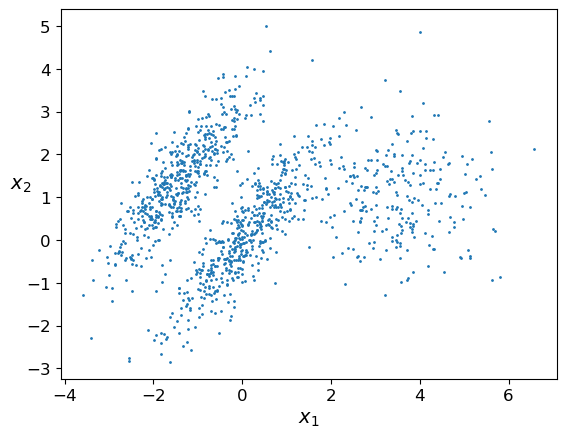

In [146]:
plot_clusters(X)

In [147]:
from sklearn.cluster import KMeans
import numpy as np

# 使用自定义初始化的KMeans
kmeans_good = KMeans(
    n_clusters=3,                                    # 3个簇
    init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), # 自定义初始中心点
    n_init=1,                                        # 只运行一次
    random_state=42
)

# 使用随机初始化的KMeans
kmeans_bad = KMeans(
    n_clusters=3,      # 3个簇
    random_state=42    # 随机种子
)

# 拟合数据
kmeans_good.fit(X)
kmeans_bad.fit(X)

# 比较两个模型的惯性值
print(f"自定义初始化惯性值: {kmeans_good.inertia_}")
print(f"随机初始化惯性值: {kmeans_bad.inertia_}")

自定义初始化惯性值: 2242.55042126599
随机初始化惯性值: 2179.6411978716374


Saving figure bad_kmeans_plot


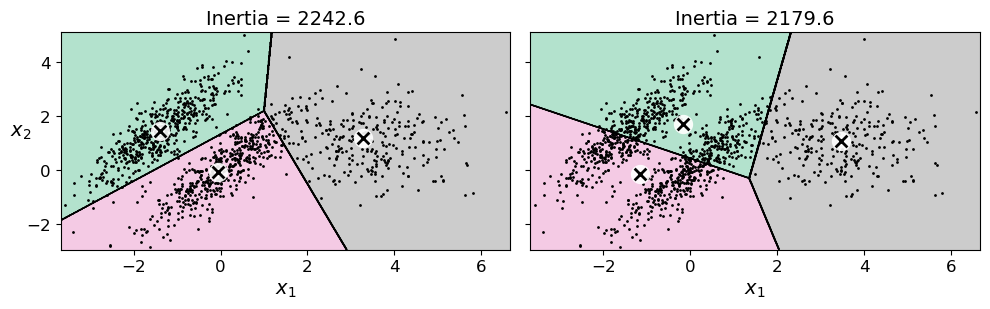

In [148]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

### Using Clustering for Image Segmentation 图像分割

In [149]:
from matplotlib.image import imread
image = imread(os.path.join("images", "9_unsupervised_learning", "ladybug.png"))
image.shape
# 读取图像数据，输出形状，三个数字分别代表高度、宽度和通道数

(533, 800, 3)

In [150]:
# 将图像从(height, width, 3)转换为(height*width, 3)
X = image.reshape(-1, 3)

# 创建KMeans模型，将颜色分为8类
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)

# 用聚类中心的颜色替换原始像素
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
# 恢复原始图像形状
segmented_img = segmented_img.reshape(image.shape)

In [151]:
import numpy as np
from sklearn.cluster import KMeans

# 存储不同分割结果
segmented_imgs = []

# 定义不同的颜色数量
n_colors = (10, 8, 6, 4, 2)

# 循环处理不同颜色数
for n_clusters in n_colors:
    # 创建并训练KMeans模型
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    
    # 获取分割结果
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    
    # 重塑图像并保存
    segmented_imgs.append(segmented_img.reshape(image.shape))

print(f"生成了{len(segmented_imgs)}个不同颜色数量的分割图像")

生成了5个不同颜色数量的分割图像


Saving figure image_segmentation_diagram


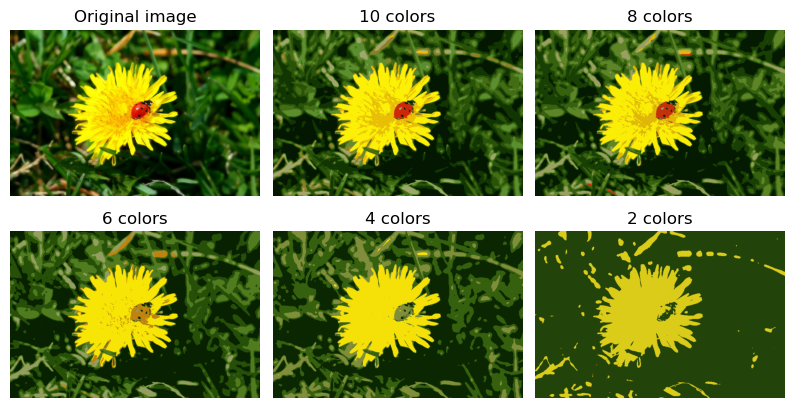

In [152]:
import matplotlib.pyplot as plt

# 创建图形
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

# 显示原始图像
plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

# 显示不同颜色数量的分割结果
for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

# 保存和显示
save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

### Using Clustering for Preprocessing

Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [153]:
from sklearn.datasets import load_digits

In [154]:
X_digits, y_digits = load_digits(return_X_y=True)

Let's split it into a training set and a test set:

In [155]:
from sklearn.model_selection import train_test_split

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Now let's fit a Logistic Regression model and evaluate it on the test set:

In [157]:
from sklearn.linear_model import LogisticRegression

In [158]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [159]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [160]:
from sklearn.pipeline import Pipeline

In [161]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [162]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9733333333333334

How much did the error rate drop?

In [163]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.1428571428571439

How about that? We reduced the error rate by over 35%! But we chose the number of clusters $k$ completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance.

In [164]:
from sklearn.model_selection import GridSearchCV

**Warning**: the following cell may take close to 20 minutes to run, or more depending on your hardware.

In [165]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.0s
[CV] END ...............................kmeans_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

Let's see what the best number of clusters is:

In [166]:
grid_clf.best_params_

{'kmeans__n_clusters': 79}

In [167]:
grid_clf.score(X_test, y_test)

0.9844444444444445

### Using Clustering for Semi-Supervised Learning

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's look at the performance of a logistic regression model when we only have 50 labeled instances:

In [168]:
n_labeled = 50

In [169]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images:

In [170]:
k = 50

In [171]:
# 创建KMeans模型
kmeans = KMeans(n_clusters=k, random_state=42)

# 计算样本到聚类中心的距离
X_digits_dist = kmeans.fit_transform(X_train)

# 找到每个聚类最具代表性的样本，距离聚类中心最近
representative_digit_idx = np.argmin(X_digits_dist, axis=0)

# 获取代表性样本
X_representative_digits = X_train[representative_digit_idx]

print(f"代表性样本数量: {len(X_representative_digits)}")
print(f"每个样本的特征数: {X_representative_digits.shape[1]}")

代表性样本数量: 50
每个样本的特征数: 64


Now let's plot these representative images and label them manually:

Saving figure representative_images_diagram


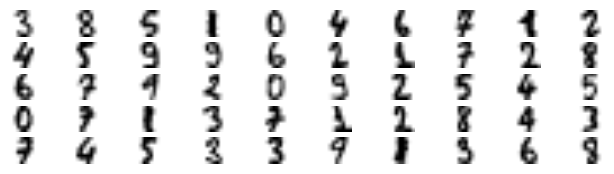

In [172]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [173]:
y_train[representative_digit_idx]

array([3, 8, 5, 1, 0, 4, 6, 7, 1, 2, 4, 5, 9, 9, 6, 2, 1, 7, 2, 8, 6, 7,
       9, 2, 0, 9, 2, 5, 4, 5, 0, 7, 1, 3, 7, 1, 2, 8, 4, 3, 7, 4, 5, 3,
       3, 9, 1, 3, 6, 8])

In [174]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 2, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [175]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.06222222222222222

Wow! We jumped from 83.3% accuracy to 91.3%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [176]:
import numpy as np

# 创建空数组存储传播的标签
y_train_propagated = np.empty(len(X_train), dtype=np.int32)

# 遍历每个簇
for i in range(k):
    # 将代表性样本的标签传播给该簇中的所有样本
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

# 验证结果
print(f"传播后的标签数量: {len(y_train_propagated)}")
print(f"标签种类: {np.unique(y_train_propagated)}")

传播后的标签数量: 1347
标签种类: [0 1 2 3 4 5 6 7 8 9]


In [177]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [178]:
log_reg.score(X_test, y_test)

0.07777777777777778

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 75th percentile closest to the centroid:

In [179]:
import numpy as np

# 设置阈值百分比
percentile_closest = 75

# 获取每个样本到其所属聚类中心的距离
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

# 遍历每个簇
for i in range(k):
    # 获取当前簇的样本
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    
    # 计算距离阈值
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    
    # 标记距离过大的样本
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

print(f"被标记的样本数: {np.sum(X_cluster_dist == -1)}")

被标记的样本数: 344


In [180]:
# 创建筛选掩码
partially_propagated = (X_cluster_dist != -1)

# 提取满足条件的样本和标签
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

# 打印信息
print(f"原始样本数: {len(X_train)}")
print(f"保留样本数: {len(X_train_partially_propagated)}")
print(f"过滤比例: {len(X_train_partially_propagated)/len(X_train):.2%}")

原始样本数: 1347
保留样本数: 1003
过滤比例: 74.46%


In [181]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [182]:
log_reg.score(X_test, y_test)

0.09333333333333334

A bit better. With just 50 labeled instances (just 5 examples per class on average!), we got 92.7% performance, which is getting closer to the performance of logistic regression on the fully labeled _digits_ dataset (which was 96.9%).

This is because the propagated labels are actually pretty good: their accuracy is close to 96%:

In [183]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.05682951146560319

You could now do a few iterations of *active learning*:
1. Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.
2. Train a new model with these additional labels.

### DBSCAN

- Density-Based Spatial Clustering of Applications with Noise
    - 基于密度的聚类算法
    - 可以发现任意形状的簇
- 核心组件
    - 核心点：
        - 在eps范围内有最少minPts个邻居的点
        - 通过core_sample_indices_获取
    - 核心样本：
        - 核心点的具体坐标值
        - 通过components_获取

In [184]:
from sklearn.datasets import make_moons

In [185]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [186]:
from sklearn.cluster import DBSCAN

In [187]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [188]:
# 前10个样本的cluster标签
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

In [189]:
# 核心样本数量
len(dbscan.core_sample_indices_)

808

In [190]:
# 前10个核心样本的索引
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [191]:
# 前3个核心样本
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [192]:
# cluster数量
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [193]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [194]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


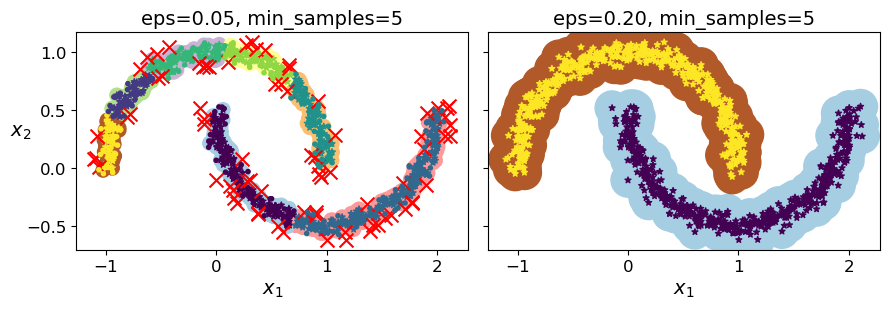

In [195]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()

# 大eps:更宽松的领域定义，更容易形成大簇，噪声点更少
# 小eps:更严格的领域定义，更容易形成小簇，噪声点更多

In [196]:
dbscan = dbscan2

In [197]:
from sklearn.neighbors import KNeighborsClassifier

In [198]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [199]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [200]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Saving figure cluster_classification_plot


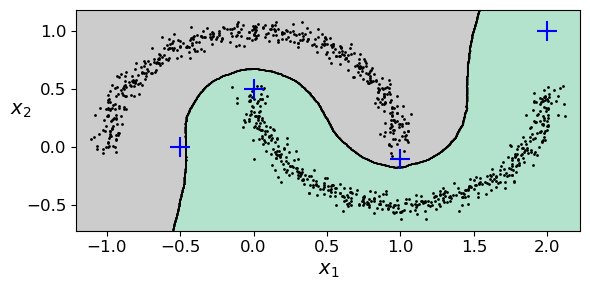

In [201]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [202]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# 找到最近的核心样本和距离
y_dist, y_pred_idx = knn.kneighbors(
    X_new,          # 新数据点
    n_neighbors=1   # 只找最近的一个邻居
)

# 获取对应的簇标签
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]

# 距离大于阈值的点标记为噪声
y_pred[y_dist > 0.2] = -1

# 展平预测结果
print("预测结果:", y_pred.ravel())
print("对应距离:", y_dist.ravel())

预测结果: [-1  0  1 -1]
对应距离: [0.43045422 0.02225568 0.06010476 0.48399468]


### Other clustering algorithms

##### Spectral clustering 谱聚类

In [203]:
from sklearn.cluster import SpectralClustering

In [204]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [205]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [206]:
np.percentile(sc1.affinity_matrix_, 95)
# 计算相似度矩阵的95%分位数

0.04251990648936265

In [207]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

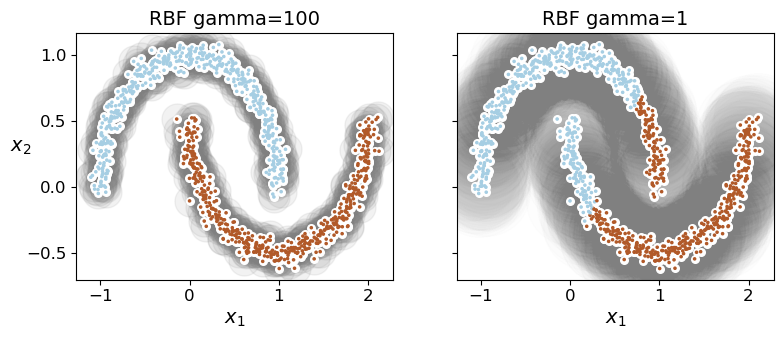

In [208]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

# 小gamma (1): 更平滑的决策边界，较大的簇
# 大gamma (100): 更细致的簇划分，可能过拟合

#### Agglomerative clustering 凝聚层次聚类

In [209]:
from sklearn.cluster import AgglomerativeClustering

In [210]:
import numpy as np
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)
# 完全链接法意味着在合并簇时，使用两个簇之间最远点的距离作为簇间距离。

In [213]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [214]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [216]:
agg.children_

# 输出:
# [[0 1]  # 第一次合并：合并索引0和1的点，形成新簇4
# [2 3]   # 第二次合并：合并索引2和3的点，形成新簇5
# [4 5]]  # 第三次合并：合并前两次形成的簇(簇4和簇5)

array([[0, 1],
       [2, 3],
       [4, 5]])

## 3.Gaussian Mixtures

In [217]:
# 第一部分：创建第一个数据集
X1, y1 = make_blobs(
    n_samples=1000,                # 1000个样本
    centers=((4, -4), (0, 0)),    # 两个中心点
    random_state=42               # 随机种子
)

# 应用线性变换（旋转和缩放）
transformation_matrix = np.array([[0.374, 0.95], [0.732, 0.598]])
X1 = X1.dot(transformation_matrix)

# 第二部分：创建第二个数据集
X2, y2 = make_blobs(
    n_samples=250,    # 250个样本
    centers=1,        # 中心点随机
    random_state=42
)

# 平移第二个数据集
X2 = X2 + [6, -8]    # 向右移动6，向下移动8

# 合并两个数据集
X = np.r_[X1, X2]    # 垂直堆叠特征
y = np.r_[y1, y2]    # 垂直堆叠标签

Let's train a Gaussian mixture model on the previous dataset:

In [218]:
from sklearn.mixture import GaussianMixture

In [219]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [220]:
gm.weights_ # 每个簇的权重,表示样本属于该簇的概率

array([0.40005972, 0.20961444, 0.39032584])

In [221]:
gm.means_ # 每个簇的均值，中心点坐标

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [222]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

Did the algorithm actually converge?

In [223]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [224]:
gm.n_iter_

4

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [225]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1], dtype=int64)

In [226]:
gm.predict_proba(X)

array([[6.76282339e-07, 2.31833274e-02, 9.76815996e-01],
       [6.74575575e-04, 1.64110061e-02, 9.82914418e-01],
       [9.99922764e-01, 1.99781831e-06, 7.52377580e-05],
       ...,
       [2.12540639e-26, 9.99999568e-01, 4.31902443e-07],
       [1.45002917e-41, 1.00000000e+00, 5.20915318e-16],
       [7.93266114e-41, 1.00000000e+00, 2.30971331e-15]])

This is a generative model, so you can sample new instances from it (and get their labels):

In [227]:
X_new, y_new = gm.sample(6) # 从模型中生成6个新样本
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

In [228]:
y_new

array([0, 0, 1, 1, 1, 2])

Notice that they are sampled sequentially from each cluster.

You can also estimate the log of the _probability density function_ (PDF) at any location using the `score_samples()` method:

In [231]:
# 计算样本的对数概率密度
log_densities = gm.score_samples(X)

print("前5个样本的对数概率密度:")
print(log_densities[:5])

print("\n概率密度值范围:")
print(f"最小值: {log_densities.min():.2f}")
print(f"最大值: {log_densities.max():.2f}")
print(f"平均值: {log_densities.mean():.2f}")

# score_samples的作用：返回每个样本点的对数概率密度，值越大表示该点出现的概率越高
# 可用于：
    # 异常检测（低概率点可能是异常值）
    # 评估模型对数据的拟合程度
    # 判断新样本是否符合已学习的分布

前5个样本的对数概率密度:
[-2.60786904 -3.57094519 -3.3302143  -2.55653008 -3.394629  ]

概率密度值范围:
最小值: -11.16
最大值: -1.96
平均值: -3.23


Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [232]:
# 创建细密网格
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)  # 从-10到10，步长为1/100
xx, yy = np.meshgrid(grid, grid)  # 创建二维网格
X_full = np.vstack([xx.ravel(), yy.ravel()]).T  # 转换为样本点格式

# 计算概率密度
pdf = np.exp(gm.score_samples(X_full))  # 将对数概率密度转换为概率密度

# 计算概率（积分应该为1）
pdf_probas = pdf * (1 / resolution) ** 2  # 乘以每个小区域的面积
total_probability = pdf_probas.sum()  # 总概率应接近1

print(f"总概率: {total_probability:.4f}")

0.9999999999225081

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [233]:
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    """
    参数:
    - clusterer: 训练好的GMM模型
    - X: 训练数据
    - resolution: 网格分辨率
    - show_ylabels: 是否显示y轴标签
    """
    # 1. 创建网格
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    
    # 2. 计算概率密度
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 3. 绘制等高线填充
    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    
    # 4. 绘制等高线
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    # 5. 绘制簇的边界
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    # 6. 绘制数据点和簇中心
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    # 7. 设置标签
    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure gaussian_mixtures_plot


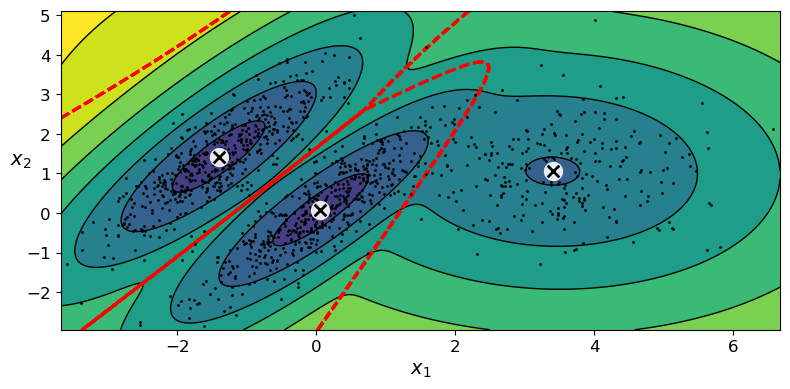

In [234]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

You can impose constraints on the covariance matrices that the algorithm looks for by setting the `covariance_type` hyperparameter:
* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

这段话解释了在使用高斯混合模型（GMM）时，你可以通过设置covariance_type这个超参数来限制算法搜索的协方差矩阵的类型。协方差矩阵决定了高斯分布（也就是我们说的“圈圈”）的形状和大小。不同的covariance_type会产生不同形状的“圈圈”，从而影响聚类的结果。

下面是这段话的中文解释：

"full"（默认）：完全自由。这种模式下，每个高斯分布（“圈圈”）都可以呈现任意的椭圆形，它们的大小和方向都可以不同。这意味着算法会尽力去拟合数据，找到最合适的椭圆形状来代表每个类簇，但这也可能导致过拟合。

"tied"：形状相同。这种模式下，所有的高斯分布（“圈圈”）都必须具有相同的形状，它们共享同一个协方差矩阵。但是，它们的大小可以不同。你可以想象成所有“圈圈”都是相似的椭圆，只是大小不一样。这种模式适用于那些你认为所有类簇的形状都差不多的情况。

"spherical"：球形。这种模式下，所有的高斯分布（“圈圈”）都必须是球形的，但是它们的直径（也就是方差）可以不同。你可以想象成所有“圈圈”都是圆形的，只是大小不一样。这种模式适用于那些你认为所有类簇都是圆形的情况。

"diag"：对角线椭圆。这种模式下，高斯分布（“圈圈”）可以是任意大小的椭圆形，但是这些椭圆的轴必须与坐标轴平行（也就是说，协方差矩阵必须是对角矩阵）。你可以想象成所有“圈圈”都是椭圆，但是它们不能倾斜，只能“正着”或“横着”。这种模式适用于那些你认为类簇的形状是轴对齐的椭圆的情况。

In [235]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [237]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


Saving figure covariance_type_plot


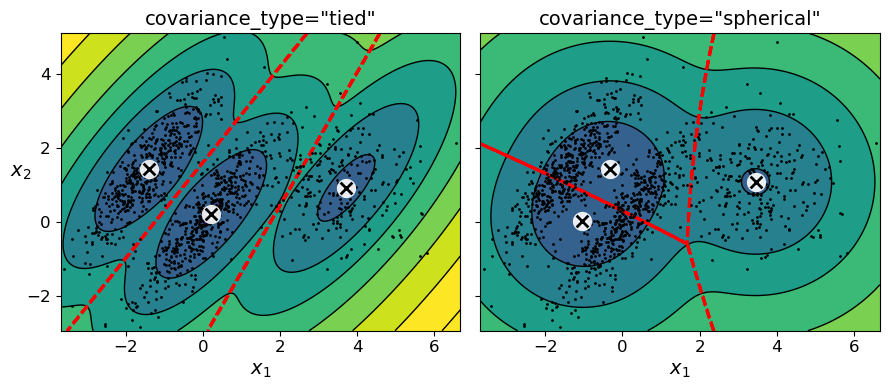

In [238]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

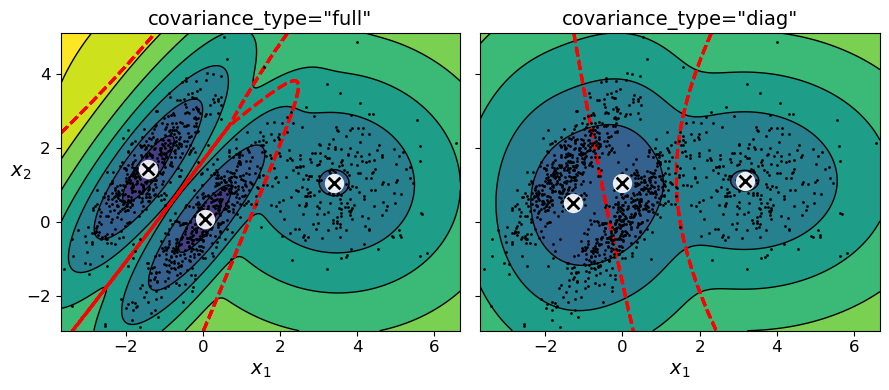

In [239]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

### Anomaly Detection Using Gaussian Mixtures

Gaussian Mixtures can be used for _anomaly detection_: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [243]:
# 使用GMM进行异常检测

# 1. 计算每个样本点的对数概率密度
densities = gm.score_samples(X)

# 2. 设置密度阈值（取第4百分位数）
density_threshold = np.percentile(densities, 4)

# 3. 找出异常点（密度低于阈值的点）
anomalies = X[densities < density_threshold]

Saving figure mixture_anomaly_detection_plot


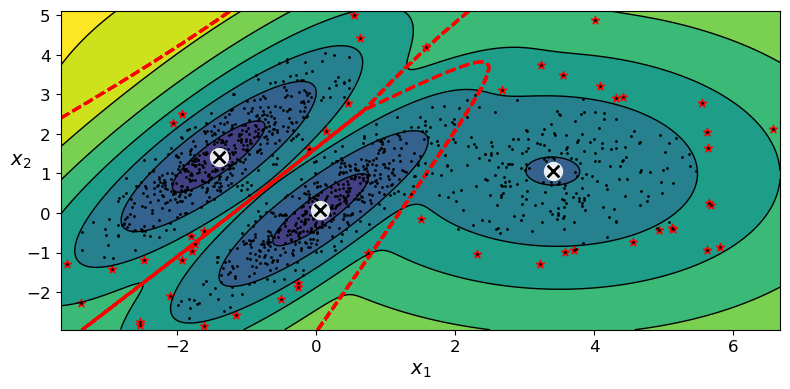

In [244]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

### Selecting the Number of Clusters

We cannot use the inertia or the silhouette score because they both assume that the clusters are spherical. Instead, we can try to find the model that minimizes a theoretical information criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$ is the number of instances.
* $p$ is the number of parameters learned by the model.
* $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data).

这段文字解释了为什么不能直接使用惯性（inertia）或轮廓系数（silhouette score）来评估高斯混合模型（GMM）的性能，并介绍了可以使用贝叶斯信息准则（BIC）或赤池信息准则（AIC）来选择最佳模型。

核心意思是：惯性（inertia）和轮廓系数（silhouette score）这两个指标都假设聚类是球形的。而高斯混合模型（GMM）的聚类形状可以是任意的椭圆形（由协方差矩阵决定），并不一定是球形。因此，使用惯性或轮廓系数来评估GMM的性能是不准确的，因为它们不适用于非球形聚类。

为了评估GMM的性能，我们需要使用其他指标，比如贝叶斯信息准则（BIC）或赤池信息准则（AIC）。这两个指标的公式如下：

BIC（贝叶斯信息准则）： BIC = log(m)p - 2log(L̂)

AIC（赤池信息准则）： AIC = 2p - 2log(L̂)

公式中：

m 是样本数量（实例个数）。
p 是模型学习到的参数数量。对于GMM来说，参数包括每个高斯分布的均值、协方差矩阵和权重。 参数越多，模型就越复杂。
L̂ 是模型似然函数的最大值。它表示在给定模型及其优化参数的情况下，观测数据 X 的条件概率。似然值越高，说明模型对数据的拟合程度越好。
BIC和AIC的共同点是：

它们都惩罚具有更多参数的模型（例如，更多聚类）。模型越复杂，过拟合的风险就越高，因此需要进行惩罚。
它们都奖励对数据拟合良好的模型（即，对观测数据给出高似然值的模型）。模型对数据拟合得越好，似然值就越高，模型也就越好。
简单来说，BIC和AIC的目标是找到一个平衡点：既要保证模型对数据拟合得足够好（高似然值），又要避免模型过于复杂（参数数量不能太多）。通常，我们会选择BIC或AIC值最小的模型，因为它代表了在模型复杂度和拟合优度之间找到了一个最佳的平衡点。

In [245]:
gm.bic(X)

8189.733705221636

In [246]:
gm.aic(X)

8102.508425106598

We could compute the BIC manually like this:

In [247]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [248]:
bic, aic

(8189.733705221636, 8102.508425106598)

In [249]:
n_params

17

There's one weight per cluster, but the sum must be equal to 1, so we have one degree of freedom less, hence the -1. Similarly, the degrees of freedom for an $n \times n$ covariance matrix is not $n^2$, but $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

In [250]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [251]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

Saving figure aic_bic_vs_k_plot


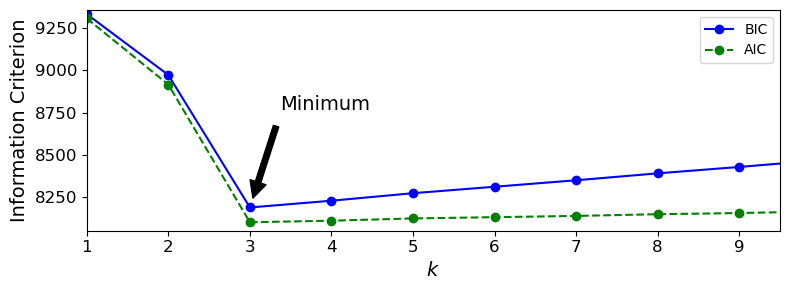

In [252]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
save_fig("aic_bic_vs_k_plot")
plt.show()

Let's search for best combination of values for both the number of clusters and the `covariance_type` hyperparameter:

In [257]:
# 初始化最小BIC为无穷大
min_bic = np.infty

# 遍历参数组合
for k in range(1, 11):  # k从1到10
    for covariance_type in ("full", "tied", "spherical", "diag"):
        # 创建并训练GMM模型
        gmm = GaussianMixture(
            n_components=k,
            n_init=10,
            covariance_type=covariance_type,
            random_state=42
        )
        # 计算BIC分数
        bic = gmm.fit(X).bic(X)
        
        # 更新最佳参数
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

print(f"最佳组件数量: {best_k}")
print(f"最佳协方差类型: {best_covariance_type}")
print(f"最小BIC分数: {min_bic:.2f}")

最佳组件数量: 3
最佳协方差类型: full
最小BIC分数: 8189.73


In [255]:
best_k

3

In [256]:
best_covariance_type

'full'

### Bayesian Gaussian Mixture Models

Rather than manually searching for the optimal number of clusters, it is possible to use instead the `BayesianGaussianMixture` class which is capable of giving weights equal (or close) to zero to unnecessary clusters. Just set the number of components to a value that you believe is greater than the optimal number of clusters, and the algorithm will eliminate the unnecessary clusters automatically.

GMM 是一个频率学 (frequentist) 模型，它通过最大似然估计 (MLE) 来确定模型参数（比如每个高斯分布的均值、协方差矩阵和权重）。  这意味着 GMM 将这些参数视为固定的未知值，并通过优化算法找到这些值的最佳估计。

BGMM 则是一个贝叶斯模型，它将模型参数视为随机变量，并为这些参数引入先验分布。  先验分布代表了我们对参数的先验知识或信念。  BGMM 通过后验分布来更新我们对参数的信念，后验分布是在观测到数据后对先验分布的修正。

简单来说，GMM 试图找到最适合数据的参数值，而 BGMM 试图找到参数的概率分布，这个分布反映了我们对参数的置信程度。

- BGMM 相比 GMM 有几个优点：
    - 自动选择聚类数量： GMM 需要预先指定聚类数量，而 BGMM 可以通过引入对聚类权重的先验分布（比如狄利克雷分布）来自动推断聚类数量。 它会自动倾向于使用较少的聚类来解释数据，避免过拟合。
    - 更好的不确定性估计： BGMM 提供了对模型参数的概率分布，这使得我们可以更好地估计模型的不确定性。 例如，我们可以计算出每个数据点属于某个聚类的概率分布，而不是像 GMM 那样只给出一个硬性的分类结果。
    - 更强的鲁棒性： BGMM 对初始参数的选择不敏感，因为它考虑了参数的所有可能取值，并通过后验分布来综合这些取值。

In [258]:
from sklearn.mixture import BayesianGaussianMixture

In [259]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

The algorithm automatically detected that only 3 components are needed:

In [260]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.  , 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

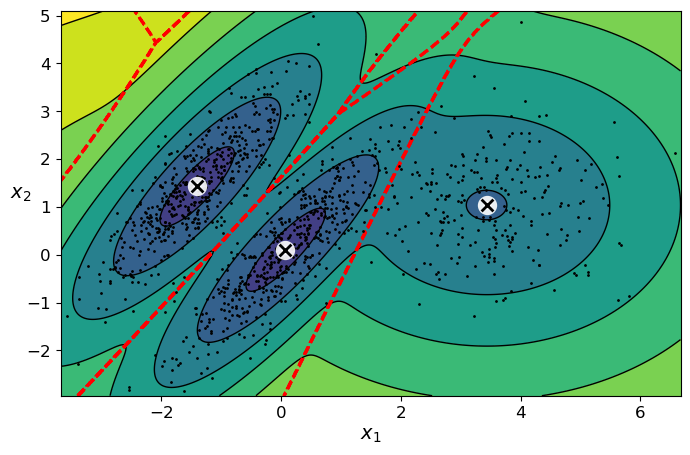

In [261]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [266]:
from sklearn.mixture import BayesianGaussianMixture
import numpy as np

# 创建低先验权重模型
bgm_low = BayesianGaussianMixture(
    n_components=10,         # 最大组件数
    max_iter=1000,          # 最大迭代次数
    n_init=1,               # 初始化次数
    weight_concentration_prior=0.01,  # 低先验权重
    random_state=42
)

# 创建高先验权重模型
bgm_high = BayesianGaussianMixture(
    n_components=10,
    max_iter=1000,
    n_init=1,
    weight_concentration_prior=10000,  # 高先验权重
    random_state=42
)

# 使用前73个样本训练
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [263]:
np.round(bgm_low.weights_, 2)

array([0.25, 0.26, 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [264]:
np.round(bgm_high.weights_, 2)

array([0.43, 0.01, 0.37, 0.01, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01])

Saving figure mixture_concentration_prior_plot


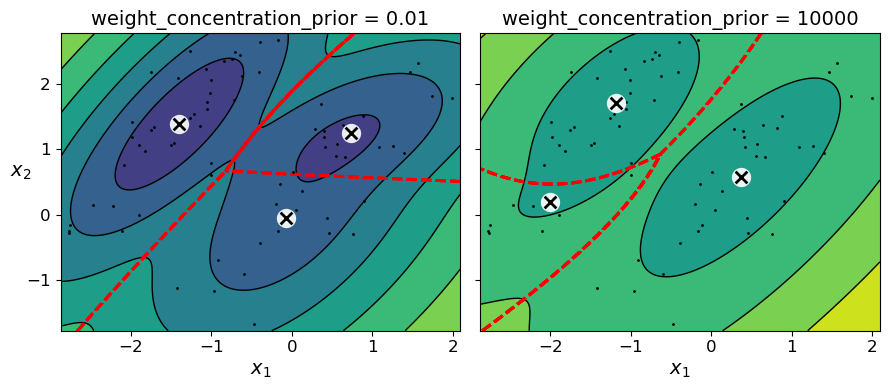

In [265]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()

Note: the fact that you see only 3 regions in the right plot although there are 4 centroids is not a bug. The weight of the top-right cluster is much larger than the weight of the lower-right cluster, so the probability that any given point in this region belongs to the top right cluster is greater than the probability that it belongs to the lower-right cluster.

In [267]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [268]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

Saving figure moons_vs_bgm_plot


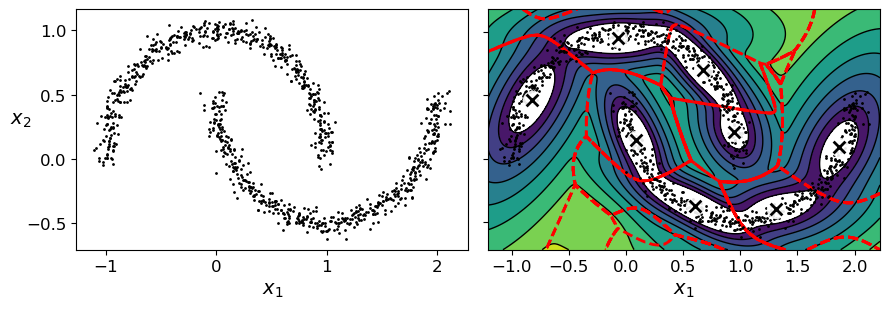

In [269]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

Oops, not great... instead of detecting 2 moon-shaped clusters, the algorithm detected 8 ellipsoidal clusters. However, the density plot does not look too bad, so it might be usable for anomaly detection.

**Likelihood Function**

In [270]:
from scipy.stats import norm

In [273]:
import numpy as np
from scipy.stats import norm

# 创建网格
xx = np.linspace(-6, 4, 101)    # x轴范围[-6,4]
ss = np.linspace(1, 2, 101)     # 标准差范围[1,2]

# 创建二维网格
XX, SS = np.meshgrid(xx, ss)

# 生成混合高斯分布
# 第一个高斯分量：均值=-1.0，权重=2
# 第二个高斯分量：均值=4.0，权重=1
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)

# 归一化
# 对每行进行归一化，确保概率密度积分为1
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

Saving figure likelihood_function_plot


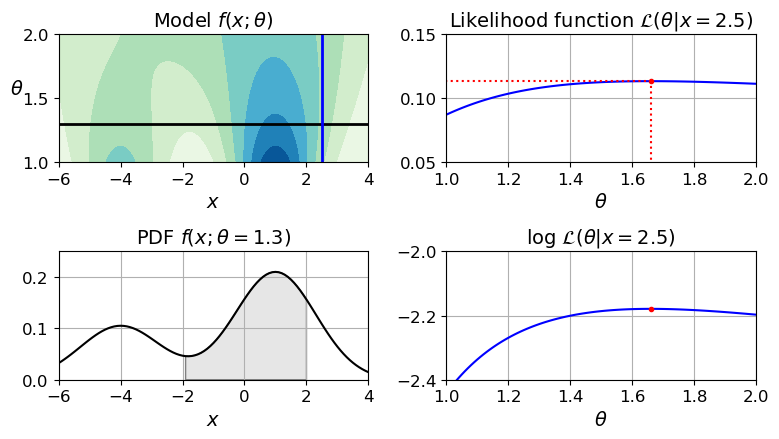

In [274]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# 创建图形
plt.figure(figsize=(8, 4.5))

# 选择索引点
x_idx = 85  # x轴的索引点
s_idx = 30  # theta轴的索引点

# 子图1：模型可视化
plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

# 子图2：似然函数
plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

# 子图3：PDF
plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

# 子图4：对数似然函数
plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

# 保存图形
save_fig("likelihood_function_plot")
plt.show()

## 练习题

### 10. Cluster the Olivetti Faces Dataset

*Exercise: The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the `sklearn.datasets.fetch_olivetti_faces()` function.*

In [275]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\周悦\scikit_learn_data


In [276]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

In [ ]:
olivetti.target # 包含40个人的标签，每人10张照片

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

*Exercise: Then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set.*

In [278]:
from sklearn.model_selection import StratifiedShuffleSplit

# 第一次分层采样：分离测试集
strat_split = StratifiedShuffleSplit(
    n_splits=1,        # 只做一次分割
    test_size=40,      # 测试集40个样本
    random_state=42
)

# 获取训练+验证集和测试集的索引
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))

# 分离测试集
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

# 第二次分层采样：分离训练集和验证集
strat_split = StratifiedShuffleSplit(
    n_splits=1,        # 只做一次分割
    test_size=80,      # 验证集80个样本
    random_state=43
)

# 获取训练集和验证集的索引
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))

# 分离训练集和验证集
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [279]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


To speed things up, we'll reduce the data's dimensionality using PCA:

In [280]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_ # 保留99%的方差所需的主成分数量

199

*Exercise: Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter).*

In [281]:
from sklearn.cluster import KMeans
import numpy as np

# 在不同k值上训练KMeans
k_range = range(5, 150, 5)  # [5,10,15,...,145]
kmeans_per_k = []

# 遍历每个k值
for k in k_range:
    print("k={}".format(k))
    # 训练KMeans模型
    kmeans = KMeans(
        n_clusters=k,      # 簇的数量
        random_state=42    # 确保结果可重现
    ).fit(X_train_pca)    # 使用PCA降维后的训练数据
    
    # 保存模型
    kmeans_per_k.append(kmeans)

print(f"总共训练了{len(kmeans_per_k)}个模型")

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145
总共训练了29个模型


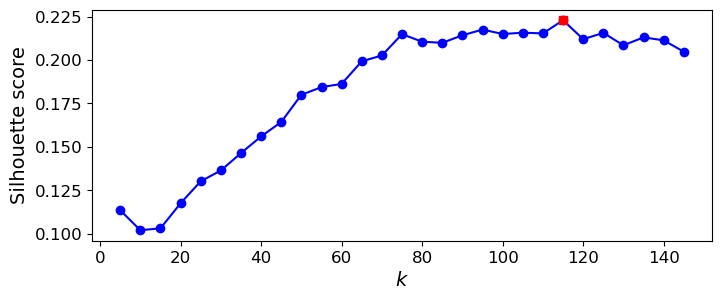

In [282]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [283]:
best_k

115

It looks like the best number of clusters is quite high, at 120. You might have expected it to be 40, since there are 40 different people on the pictures. However, the same person may look quite different on different pictures (e.g., with or without glasses, or simply shifted left or right).

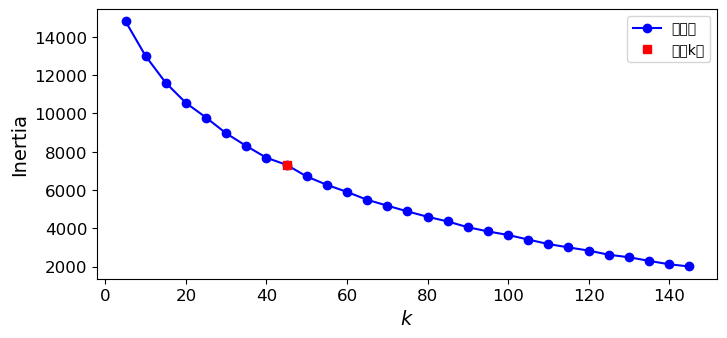

In [285]:
import matplotlib.pyplot as plt
import numpy as np

# 计算每个模型的惯性值
inertias = [model.inertia_ for model in kmeans_per_k]

# 找到最佳k值（肘部位置）
best_index = np.argmin(np.diff(np.diff(inertias))) + 1
best_k = k_range[best_index]
best_inertia = inertias[best_index]

# 绘制惯性值曲线
plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-", label="惯性值")
plt.plot(best_k, best_inertia, "rs", label="最佳k值")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.legend()
plt.show()

The optimal number of clusters is not clear on this inertia diagram, as there is no obvious elbow, so let's stick with k=120.

In [286]:
best_model = kmeans_per_k[best_index]

*Exercise: Visualize the clusters: do you see similar faces in each cluster?*

簇 0


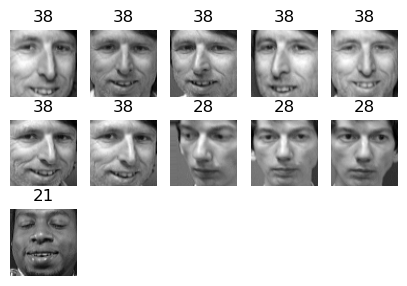

簇 1


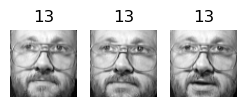

簇 2


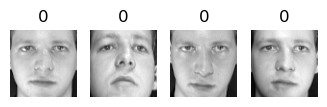

簇 3


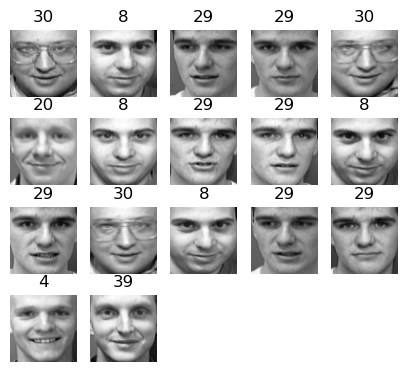

簇 4


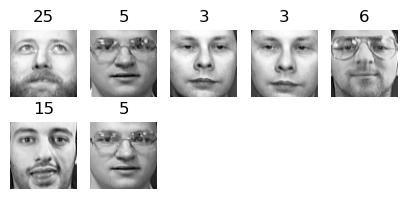

簇 5


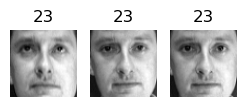

簇 6


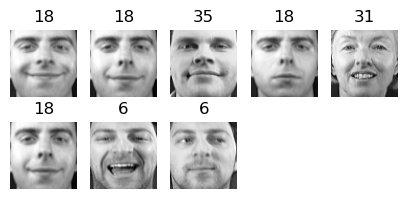

簇 7


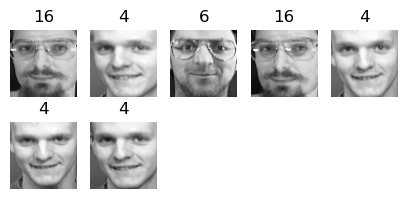

簇 8


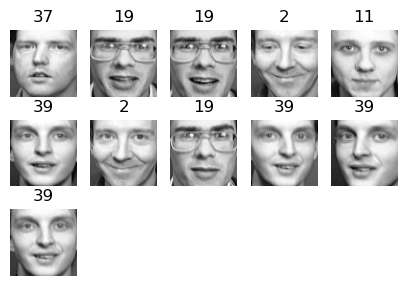

簇 9


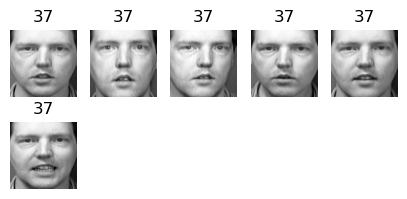

簇 10


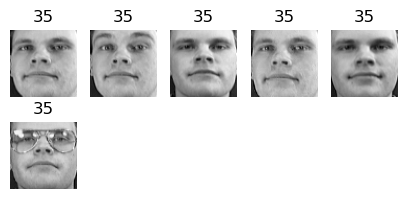

簇 11


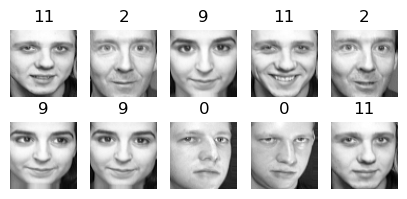

簇 12


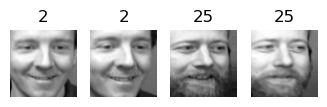

簇 13


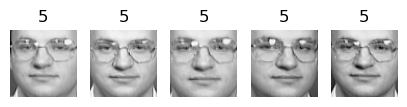

簇 14


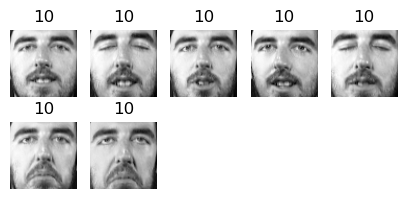

簇 15


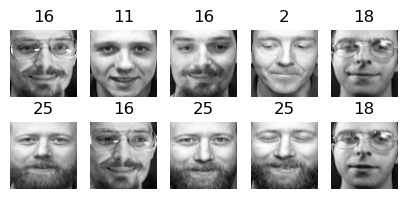

簇 16


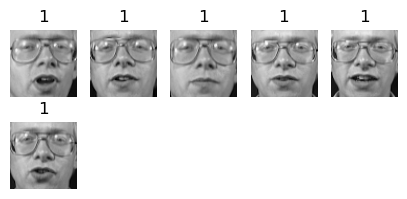

簇 17


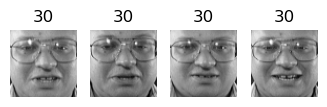

簇 18


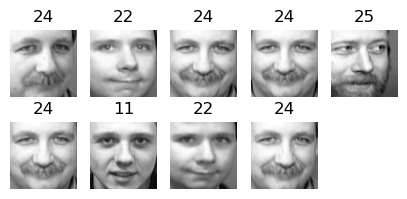

簇 19


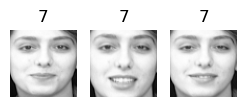

簇 20


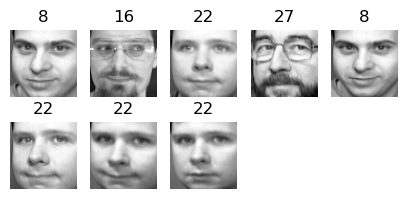

簇 21


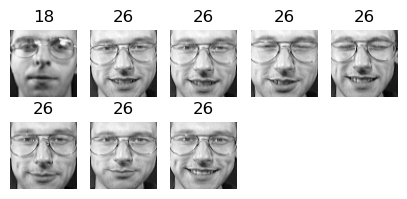

簇 22


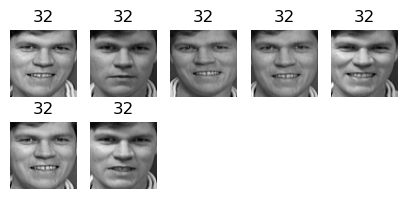

簇 23


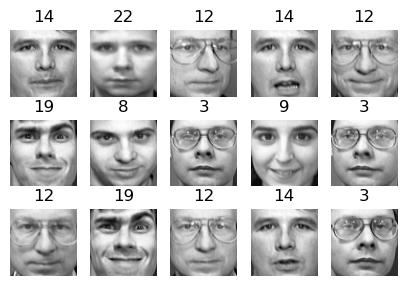

簇 24


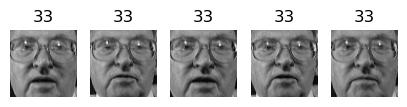

簇 25


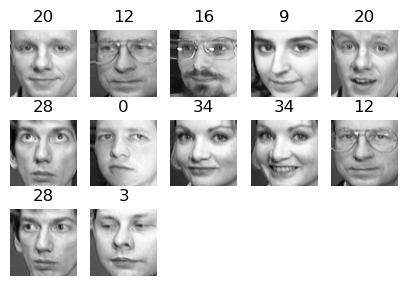

簇 26


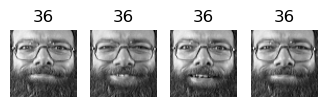

簇 27


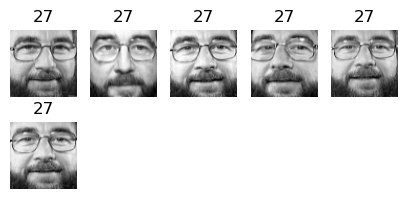

簇 28


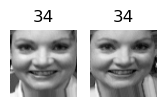

簇 29


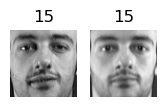

簇 30


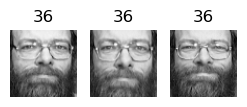

簇 31


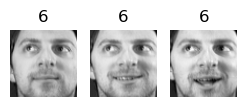

簇 32


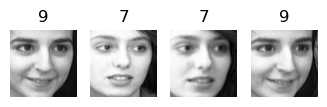

簇 33


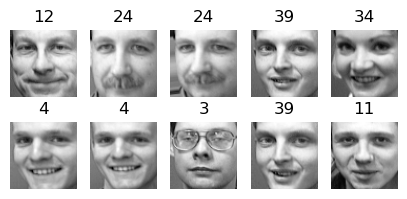

簇 34


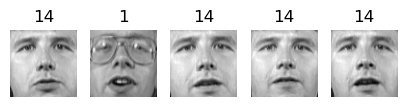

簇 35


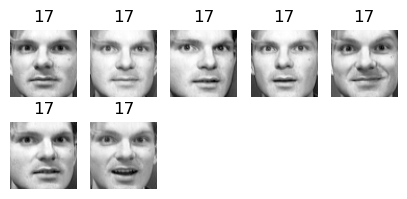

簇 36


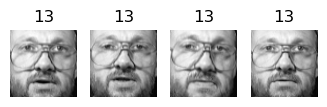

簇 37


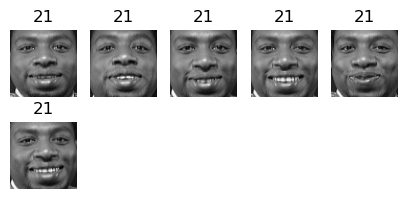

簇 38


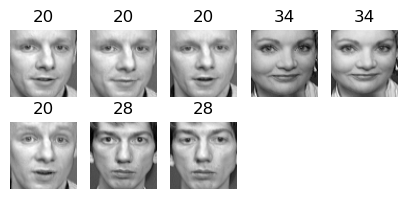

簇 39


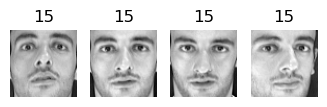

簇 40


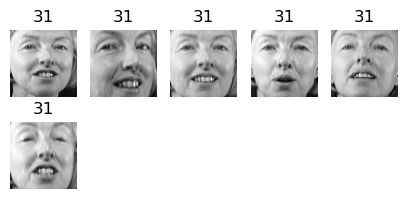

簇 41


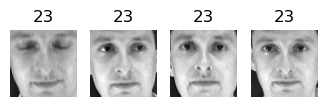

簇 42


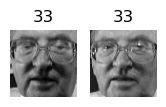

簇 43


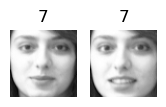

簇 44


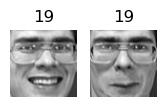

In [287]:
def plot_faces(faces, labels, n_cols=5):
    """
    绘制人脸图像网格
    参数:
    - faces: 人脸图像数组
    - labels: 对应的标签
    - n_cols: 每行显示的图像数
    """
    # 重塑图像为64x64
    faces = faces.reshape(-1, 64, 64)
    
    # 计算需要的行数
    n_rows = (len(faces) - 1) // n_cols + 1
    
    # 创建图形
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    
    # 绘制每张人脸
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

# 遍历显示每个簇的人脸
for cluster_id in np.unique(best_model.labels_):
    print("簇", cluster_id)
    # 获取当前簇的所有人脸
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    # 显示该簇的所有人脸
    plot_faces(faces, labels)

About 2 out of 3 clusters are useful: that is, they contain at least 2 pictures, all of the same person. However, the rest of the clusters have either one or more intruders, or they have just a single picture.

Clustering images this way may be too imprecise to be directly useful when training a model (as we will see below), but it can be tremendously useful when labeling images in a new dataset: it will usually make labelling much faster.

### 11. Using Clustering as Preprocessing for Classification

*Exercise: Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set.*

In [288]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

0.9

*Exercise: Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set.*

In [289]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_valid_reduced, y_valid)

0.7375

Yikes! That's not better at all! Let's see if tuning the number of clusters helps.

*Exercise: Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach?*

We could use a `GridSearchCV` like we did earlier in this notebook, but since we already have a validation set, we don't need K-fold cross-validation, and we're only exploring a single hyperparameter, so it's simpler to just run a loop manually:

In [291]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

# 尝试不同的簇数
for n_clusters in k_range:
    # 创建Pipeline
    pipeline = Pipeline([
        ("kmeans", KMeans(
            n_clusters=n_clusters, 
            random_state=42)
        ),
        ("forest_clf", RandomForestClassifier(
            n_estimators=150, 
            random_state=42)
        )
    ])
    
    # 训练Pipeline
    pipeline.fit(X_train_pca, y_train)
    
    # 评估模型
    score = pipeline.score(X_valid_pca, y_valid)
    print(f"簇数={n_clusters}, 准确率={score:.3f}")

簇数=5, 准确率=0.388
簇数=10, 准确率=0.487
簇数=15, 准确率=0.588
簇数=20, 准确率=0.613
簇数=25, 准确率=0.637
簇数=30, 准确率=0.613
簇数=35, 准确率=0.713
簇数=40, 准确率=0.688
簇数=45, 准确率=0.738
簇数=50, 准确率=0.725
簇数=55, 准确率=0.725
簇数=60, 准确率=0.725
簇数=65, 准确率=0.700
簇数=70, 准确率=0.713
簇数=75, 准确率=0.738
簇数=80, 准确率=0.762
簇数=85, 准确率=0.700
簇数=90, 准确率=0.750
簇数=95, 准确率=0.750
簇数=100, 准确率=0.750
簇数=105, 准确率=0.762
簇数=110, 准确率=0.750
簇数=115, 准确率=0.713
簇数=120, 准确率=0.787
簇数=125, 准确率=0.762
簇数=130, 准确率=0.750
簇数=135, 准确率=0.762
簇数=140, 准确率=0.713
簇数=145, 准确率=0.725


Oh well, even by tuning the number of clusters, we never get beyond 80% accuracy. Looks like the distances to the cluster centroids are not as informative as the original images.

*Exercise: What if you append the features from the reduced set to the original features (again, searching for the best number of clusters)?*

In [292]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [293]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

0.9

That's a bit better, but still worse than without the cluster features. The clusters are not useful to directly train a classifier in this case (but they can still help when labelling new training instances).

### 12. A Gaussian Mixture Model for the Olivetti Faces Dataset

*Exercise: Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset's dimensionality (e.g., use PCA, preserving 99% of the variance).*

In [294]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

*Exercise: Use the model to generate some new faces (using the `sample()` method), and visualize them (if you used PCA, you will need to use its `inverse_transform()` method).*

In [295]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

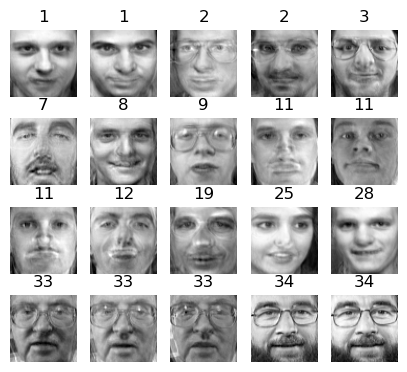

In [296]:
plot_faces(gen_faces, y_gen_faces)

*Exercise: Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the `score_samples()` method for normal images and for anomalies).*

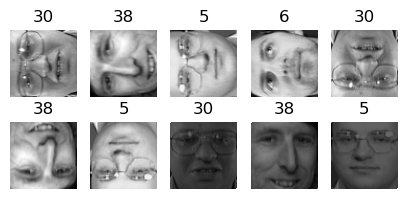

In [297]:
# 1. 创建旋转后的图像
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

# 2. 创建水平翻转的图像
n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

# 3. 创建变暗的图像
n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3  # 降低亮度
y_darkened = y_train[:n_darkened]

# 4. 合并所有变形图像
X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

# 5. 显示结果
plot_faces(X_bad_faces, y_bad)

In [298]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [299]:
gm.score_samples(X_bad_faces_pca) # 10张坏图片的对数概率密度，值越大越正常

array([-1.85962738e+07, -1.73014077e+07, -4.15206353e+07, -4.81260197e+07,
       -3.20479003e+07, -1.35426888e+07, -2.92374094e+07, -9.25150247e+07,
       -1.03272372e+08, -5.41696746e+07])

The bad faces are all considered highly unlikely by the Gaussian Mixture model. Compare this to the scores of some training instances:

In [300]:
gm.score_samples(X_train_pca[:10])

array([1163.02020912, 1112.17308195, 1156.32132891, 1170.67602861,
       1073.69246129, 1139.89252785, 1113.76629933, 1073.6924489 ,
       1048.17522712, 1048.17520596])

### 13. Using Dimensionality Reduction Techniques for Anomaly Detection

*Exercise: Some dimensionality reduction techniques can also be used for anomaly detection. For example, take the Olivetti faces dataset and reduce it with PCA, preserving 99% of the variance. Then compute the reconstruction error for each image. Next, take some of the modified images you built in the previous exercise, and look at their reconstruction error: notice how much larger the reconstruction error is. If you plot a reconstructed image, you will see why: it tries to reconstruct a normal face.*

We already reduced the dataset using PCA earlier:

In [301]:
X_train_pca

array([[ 3.78081918e+00, -1.85479450e+00, -5.14403152e+00, ...,
        -1.35628670e-01, -2.14084208e-01,  6.11921661e-02],
       [ 1.01488476e+01, -1.52754545e+00, -7.66974270e-01, ...,
         1.23931892e-01, -1.35264695e-01, -2.32628509e-02],
       [-1.00152950e+01,  2.87728786e+00, -9.19881999e-01, ...,
         7.26091862e-02, -2.96017667e-03,  1.24891095e-01],
       ...,
       [ 2.47587204e+00,  2.95597243e+00,  1.29985440e+00, ...,
        -2.09091045e-02,  3.48537341e-02, -1.54331639e-01],
       [-3.22031331e+00,  5.34897804e+00,  1.39426863e+00, ...,
         5.75547479e-02, -2.28312373e-01,  1.55573532e-01],
       [-9.22877073e-01, -3.64702916e+00,  2.26087880e+00, ...,
         1.36847198e-01, -6.91283494e-02,  6.26949072e-02]], dtype=float32)

In [302]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [303]:
reconstruction_errors(pca, X_train).mean()

0.0001920535

In [304]:
reconstruction_errors(pca, X_bad_faces).mean()

0.004707354

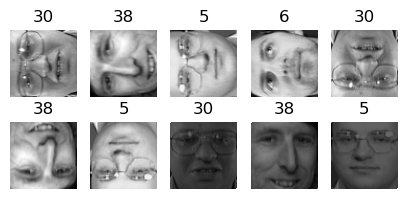

In [305]:
plot_faces(X_bad_faces, y_bad)

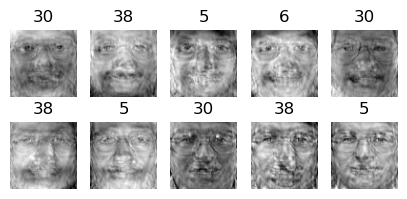

In [306]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad)